Machine Learning Plus. (2018). Topic Modeling with Gensim (Python). Retrieved April 1, 2019 from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

Import libraries

In [1]:
import re, string
import numpy as np
import pandas as pd
from pprint import pprint
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TKW\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TKW\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TKW\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\TKW\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Import training data

In [2]:
train = pd.read_csv("C:/Users/TKW/Desktop/train.csv")
print(len(train))
train.head(5)

31418


,Comments,Insulting,Anti Government,Xenophobic,Racist,Sexual
0,FUCK FOREIGN TALENT,1,0,1,0,0
1,I LOVE THE GOVERNMENT,0,0,0,0,0
2,WOMEN SHOULD BE IN THE KITCHEN,1,0,0,0,0
3,I still don't know how he was crushed. What we...,1,1,0,0,0
4,In the first place how did a doctor become a d...,1,1,0,0,0


Import stopwords and text cleaning

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use','got','get','include','includ','including',
                   'like','go','u','also','liao','still','one','ah','1','2','take','say','think',
                   'due','really','need','anyone','well','many','want','go','come','year','make',
                   'ah','go','wah','go','good','see','know'])

In [4]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def cleaning(sentences):
    result = []
    for text in sentences:
        text = str(text)
        text = text.lower()
        text = re.sub(r"\'m", " am", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"won\'t", "will not", text)
        text = re.sub(r"can\'t", "cannot", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'bout", "about", text)
        text = re.sub(r"\'til", "until", text)
        text = re.sub(r"""[^a-zA-Z0-9-!$%^&@*()+|=`{}\[\]:;"'<>?,.\/\s]"""," ",text)
        text = re.sub(r"\bft\b|\bforeigntalent\b","foreign talent",text)
        text = re.sub(r"\bgovt\b|\bgahment\b|\bgahmen\b|\bgov\b","government",text)
        text = re.sub(r"\bpapies\b|\bpapees\b","pappies",text)
        text = re.sub(r"\bchi bai\b|\bchibai\b|\bchee bye\b|\bcheebye\b","cb",text)
        text = re.sub(r"\bfk\b|\bfck\b","fuck",text)
        text = re.sub(r"\bkanina\b|\bkanena\b","knn",text)
        text = re.sub(r"\blky\b","lee kuan yew",text)
        text = re.sub(r"\blhl\b|\bpm lee\b","lee hsien loong",text)
        if len(text.split()) == 0:
            continue
        then = []
        for word in text.split():
            if word not in stop_words:
                then.append(word)
        result.append(then)
    result = [" ".join(x) for x in result]
    return result

In [5]:
clean_train = cleaning(train["Comments"])
train['Comments'] = clean_train
train.head(5)

,Comments,Insulting,Anti Government,Xenophobic,Racist,Sexual
0,fuck foreign talent,1,0,1,0,0
1,love government,0,0,0,0,0
2,women kitchen,1,0,0,0,0
3,crushed. 3 material time accident happened. ne...,1,1,0,0,0
4,first place doctor become defense minister mil...,1,1,0,0,0


Tokenise words

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(train['Comments']))

Create bigrams and trigrams

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['fuck', 'foreign_talent']


In [8]:
# Define functions for bigrams, trigrams, and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['fuck', 'foreign_talent']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Output some examples of terms

In [11]:
# Excerpt of human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]]

[[('foreign_talent', 1), ('fuck', 1)],
 [('government', 1), ('love', 1)],
 [('kitchen', 1), ('woman', 1)],
 [('accident', 1),
  ('crush', 1),
  ('day', 1),
  ('enlighten', 1),
  ('happen', 1),
  ('major', 1),
  ('material', 1),
  ('need', 1),
  ('new', 1),
  ('nothing', 1),
  ('surgery', 1),
  ('time', 1)]]

Iterate models and obtain coherence values 

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
# Calculate coherence values from 5 to 19 topics.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=20, step=1)

Determine best number of topics using coherence value

In [16]:
coherence_values

[0.24256735276366612,
 0.21779495242508418,
 0.28315220919434275,
 0.2615400957632768,
 0.2859719844960509,
 0.2906892159870193,
 0.3081965137076001,
 0.29595836319041685,
 0.29095642244292874,
 0.31324908659521944,
 0.3237098272206155,
 0.32850557163478344,
 0.3199870324181098,
 0.3115856661777123,
 0.3117569130933564]

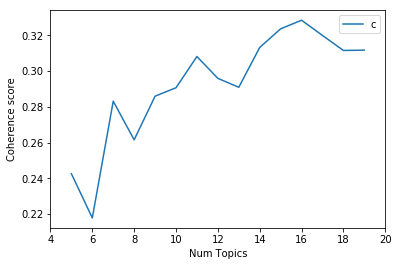

In [19]:
# Show graph
start=5
limit=20
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xticks([4,6,8,10,12,14,16,18,20])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Generate topics

In [20]:
print(max(coherence_values))

# 16 topics gives the highest coherence value
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=16, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

0.32850557163478344


In [21]:
# Print the keywords in the 16 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.158*"go" + 0.121*"look" + 0.079*"back" + 0.069*"love" + 0.060*"actually" '
  '+ 0.057*"always" + 0.056*"get" + 0.045*"long" + 0.045*"lot" + '
  '0.044*"story"'),
 (1,
  '0.179*"time" + 0.132*"day" + 0.073*"first" + 0.065*"quite" + 0.050*"place" '
  '+ 0.049*"high" + 0.040*"must" + 0.035*"night" + 0.029*"especially" + '
  '0.023*"become"'),
 (2,
  '0.181*"give" + 0.130*"new" + 0.080*"last" + 0.069*"well" + 0.061*"week" + '
  '0.058*"year" + 0.053*"month" + 0.051*"next" + 0.022*"write" + '
  '0.014*"block"'),
 (3,
  '0.117*"find" + 0.077*"singaporean" + 0.068*"anything" + 0.044*"police" + '
  '0.039*"woman" + 0.039*"idea" + 0.036*"government" + 0.035*"course" + '
  '0.035*"taste" + 0.032*"law"'),
 (4,
  '0.169*"thank" + 0.089*"may" + 0.066*"already" + 0.057*"old" + 0.056*"show" '
  '+ 0.046*"better" + 0.042*"watch" + 0.039*"level" + 0.035*"eye" + '
  '0.023*"pass"'),
 (5,
  '0.168*"people" + 0.123*"would" + 0.094*"money" + 0.068*"help" + '
  '0.040*"burn" + 0.039*"good" + 0.031